The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


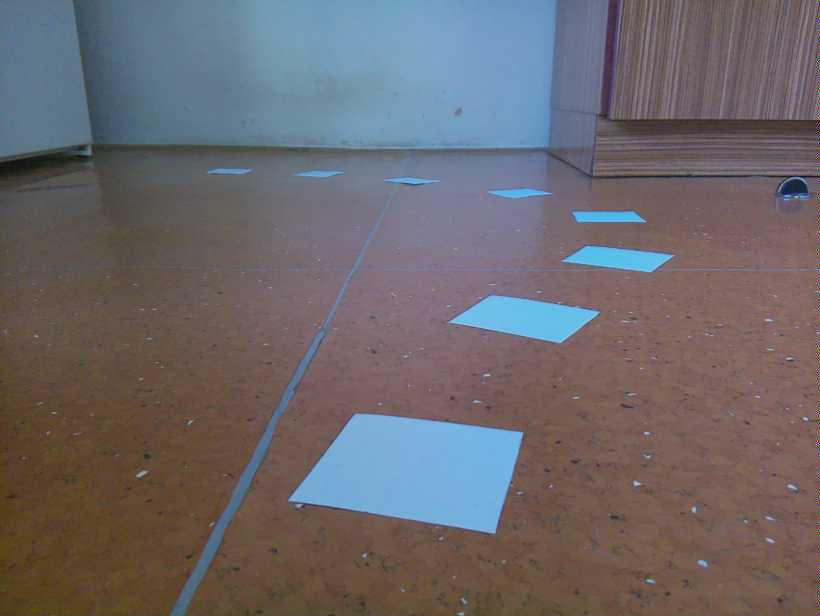

In [17]:
%load_ext autoreload
%autoreload 2

import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image

from modules.recorder import RecordReader
from datalink.data import Position, Rotation, Pose, ImageParams, ProcessedRealData
from utils.paths import record_path

import warnings
warnings.simplefilter('ignore', np.RankWarning)

# Foos
# -------------------------------------------------------------------------------------------------------------

def update_hsv_filter_with_cv2(planner):
    def nothing(x):
        pass

    # Create a window
    cv2.namedWindow("HSV Filter")

    # Create trackbars for lower and upper HSV bounds
    cv2.createTrackbar("Lower H", "HSV Filter", 0, 180, nothing)
    cv2.createTrackbar("Lower S", "HSV Filter", 0, 255, nothing)
    cv2.createTrackbar("Lower V", "HSV Filter", 200, 255, nothing)
    cv2.createTrackbar("Upper H", "HSV Filter", 180, 180, nothing)
    cv2.createTrackbar("Upper S", "HSV Filter", 30, 255, nothing)
    cv2.createTrackbar("Upper V", "HSV Filter", 255, 255, nothing)

    while True:
        # Get current positions of trackbars
        lower_h = cv2.getTrackbarPos("Lower H", "HSV Filter")
        lower_s = cv2.getTrackbarPos("Lower S", "HSV Filter")
        lower_v = cv2.getTrackbarPos("Lower V", "HSV Filter")
        upper_h = cv2.getTrackbarPos("Upper H", "HSV Filter")
        upper_s = cv2.getTrackbarPos("Upper S", "HSV Filter")
        upper_v = cv2.getTrackbarPos("Upper V", "HSV Filter")

        lower_white = np.array([lower_h, lower_s, lower_v])
        upper_white = np.array([upper_h, upper_s, upper_v])

        hsv_image = cv2.cvtColor(planner.bgr_image, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv_image, lower_white, upper_white)

        kernel = np.ones((2, 2), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        filtered_image = cv2.bitwise_and(hsv_image, hsv_image, mask=mask)
        filtered_image_bgr = cv2.cvtColor(filtered_image, cv2.COLOR_HSV2BGR)

        # Display the filtered image
        cv2.imshow("Filtered Image", filtered_image_bgr)

        # Break the loop when 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()


reader = RecordReader()

path_roadframe = record_path("1742971515013551600")
data: list = reader.read(path_roadframe, ProcessedRealData)
frame: ProcessedRealData = data[0]

jpg = frame.original.sensor_fusion.camera.jpg
display(Image(data=jpg))

In [18]:
def rpi_v2_intrinsic_matrix(img_width, img_height, binning_factor=2):
    assert binning_factor in [1, 2, 4], "Binning factor not in {1, 2, 4}"
    focal_len_mm = 3.04
    pixel_size_mm = 0.00112
    focal_len_pixels = focal_len_mm / pixel_size_mm

    # Binning combines nearby (2 or 4 pixel values into one)
    fx = fy = focal_len_pixels / binning_factor
    cx, cy = img_width / 2, img_height / 2

    return np.array(
        [
            [fx, 0, cx],
            [0, fy, cy],
            [0, 0, 1],
        ]
    )


def unreal_engine_intrinsic_matrix(img_width: int, img_height: int, fov_deg: int):
    fov = np.deg2rad(fov_deg)
    a = (img_width / 2.0) / np.tan(fov / 2.0)  # Alpha
    cx, cy = img_width / 2, img_height / 2
    return np.array(
        [
            [a, 0, cx],
            [0, a, cy],
            [0, 0, 1],
        ]
    )


class Camera:
    def __init__(self, pose: Pose, img_params: ImageParams):
        self.pose = pose
        self.position = self.pose.position
        self.rotation = self.pose.rotation
        self.img_params = img_params

        self.M = self.intrinsic_matrix()
        self.M_i = np.linalg.inv(self.M)

        self.R_rc = self.rotation_matrix()
        self.R_cr = self.R_rc.T

        self.T_rc = np.array([self.position.x, self.position.y, self.position.z])
        self.T_cr = self.T_rc * -1.0

        self.H_cr = np.eye(4)
        self.H_cr[:3, :3] = self.R_cr
        self.H_cr[:3, 3] = self.T_cr
        self.H_rc = np.linalg.inv(self.H_cr)

        self.road_normal_camera_frame = self.R_rc @ np.array([0, 1, 0])

        self.xy_roadframe_iso8855 = self.calc_or_load_xy_roadframe_iso8855()
        self.xyz_camframe = self.calc_or_load_xyz_camframe()

    def intrinsic_matrix(self) -> np.ndarray:
        raise NotImplementedError("Use a child class for a specific camera")

    def rotation_matrix(self) -> np.ndarray:
        roll = np.deg2rad(self.rotation.roll)
        pitch = np.deg2rad(self.rotation.pitch)
        yaw = np.deg2rad(self.rotation.yaw)
        cr, sr = np.cos(roll), np.sin(roll)
        cp, sp = np.cos(pitch), np.sin(pitch)
        cy, sy = np.cos(yaw), np.sin(yaw)
        return np.array(
            [
                [cr * cy + sp * sr + sy, cr * sp * sy - cy * sr, -cp * sy],
                [cp * sr, cp * cr, sp],
                [cr * sy - cy * sp * sr, -cr * cy * sp - sr * sy, cp * cy],
            ]
        )

    def calc_or_load_xy_roadframe_iso8855(self):
        w, h, fov_deg = self.img_params.width, self.img_params.height, self.img_params.fov_deg
        file_name = f"cache_xy_roadframe_iso8855_{w}x{h}_fov{fov_deg}.npy"
        file_path = file_name
        xy_roadframe_iso8855 = None
        try:
            xy_roadframe_iso8855 = np.load(file_path)
            print(f"Loaded cached data from {file_path}")
        except FileNotFoundError:
            xy_roadframe_iso8855 = self.image2xy_roadframe_iso8855()
            # np.save(file_path, xy_roadframe_iso8855)
            # print(f"Saved cache data to {file_path}")
        return xy_roadframe_iso8855

    def calc_or_load_xyz_camframe(self):
        w, h, fov_deg = self.img_params.width, self.img_params.height, self.img_params.fov_deg
        file_name = f"cache_xy_camframe_{w}x{h}_fov{fov_deg}.npy"
        file_path = file_name
        xyz_camframe = None
        try:
            xyz_camframe = np.load(file_path)
            print(f"Loaded cached data from {file_path}")
        except FileNotFoundError:
            xyz_camframe = self.image2xyz_camframe()
            # np.save(file_path, xyz_camframe)
            # print(f"Saved cache data to {file_path}")
        return xyz_camframe

    def cam2road(self, vec: np.ndarray) -> np.ndarray:
        return (self.R_cr @ vec) + self.T_cr

    def road2cam(self, vec: np.ndarray) -> np.ndarray:
        return self.R_rc @ (vec + self.T_rc)

    def uv2xyz_camframe(self, u: int, v: int) -> np.ndarray:
        image_point = [u, v, 1]
        direction_vector = self.M_i @ image_point
        scaling_factor = self.position.y / (self.road_normal_camera_frame @ direction_vector)
        xyz_c = scaling_factor * direction_vector
        return xyz_c

    def xyz_camframe2uv(self, xyz: np.ndarray) -> np.ndarray:
        uvw = self.M @ xyz
        uvw /= uvw[2]
        u, v = int(uvw[0]), int(uvw[1])
        return np.array([u, v])

    def uv2xyz_roadframe(self, u: int, v: int) -> np.ndarray:
        xyz_c = self.uv2xyz_camframe(u, v)
        return self.cam2road(xyz_c)

    def uv2xyz_roadframe_iso8855(self, u: int, v: int) -> np.ndarray:
        x, y, z = self.uv2xyz_roadframe(u, v)
        return np.array([z, -x, -y])

    def xyz_roadframe2uv(self, xyz):
        xyz_camframe = self.road2cam(xyz)
        return self.xyz_camframe2uv(xyz_camframe)

    def xyz_roadframe_iso88552uv(self, xyz: np.ndarray) -> np.ndarray:
        x, y, z = -xyz[1], -xyz[2], xyz[0]
        return self.xyz_roadframe2uv(np.array([x, y, z]))

    def image2xy_roadframe_iso8855(self) -> np.ndarray:
        # TODO: make fast
        xy = np.zeros((self.img_params.width, self.img_params.height, 2))
        for u in range(self.img_params.width):
            for v in range(self.img_params.height):
                x, y, _ = self.uv2xyz_roadframe_iso8855(u, v)
                xy[u, v] = x, y
        return xy

    def image2xyz_camframe(self) -> np.ndarray:
        xyz = np.zeros((self.img_params.width, self.img_params.height, 3))
        for u in range(self.img_params.width):
            for v in range(self.img_params.height):
                xyz[u, v, :2] = self.uv2xyz_camframe(u, v)[:2]
        return xyz


class RPiv2Camera(Camera):
    def __init__(self, pose, img_params):
        super().__init__(pose, img_params)

    def intrinsic_matrix(self):
         return rpi_v2_intrinsic_matrix(self.img_params.width, self.img_params.height)


class UnrealEngineCamera(Camera):
    def __init__(self, pose, img_params):
        super().__init__(pose, img_params)

    def intrinsic_matrix(self):
        return unreal_engine_intrinsic_matrix(
            self.img_params.width, self.img_params.height, self.img_params.fov_deg
        )
    

    

In [19]:
import unittest
import numpy as np
from unittest.mock import patch

class TestCamera(unittest.TestCase):
    def setUp(self):
        self.pose = Pose(position=Position(0, 0.135, 0), rotation=Rotation(0, -15.05, 0))
        self.img_params = ImageParams(width=820, height=616, fov_deg=90)
        
        # Use UnrealEngineCamera for testing since Camera is abstract
        self.camera = UnrealEngineCamera(self.pose, self.img_params)
    
    def test_initialization(self):
        # Test that matrices and transforms are created correctly
        self.assertEqual(self.camera.pose.position.y, 0.135)
        self.assertEqual(self.camera.rotation.pitch, -15.05)
        self.assertTrue(hasattr(self.camera, 'M'))
        self.assertTrue(hasattr(self.camera, 'R_rc'))
        self.assertTrue(hasattr(self.camera, 'H_cr'))
        
    def test_coordinate_transforms(self):
        # Test camera to road transforms
        test_point_cam = np.array([1.0, 2.0, 3.0])
        point_road = self.camera.cam2road(test_point_cam)
        point_cam_again = self.camera.road2cam(point_road)
        np.testing.assert_array_almost_equal(test_point_cam, point_cam_again)
    
    def test_uv_transforms(self):
        # Test image coordinates to 3D coordinates
        u, v = 400, 300
        xyz_cam = self.camera.uv2xyz_camframe(u, v)
        uv_again = self.camera.xyz_camframe2uv(xyz_cam)
        self.assertAlmostEqual(u, uv_again[0], delta=1)
        self.assertAlmostEqual(v, uv_again[1], delta=1)
        
    def test_roadframe_transforms(self):
        # Test image to road frame coordinates
        u, v = 400, 300
        xyz_road = self.camera.uv2xyz_roadframe(u, v)
        uv_again = self.camera.xyz_roadframe2uv(xyz_road)
        self.assertAlmostEqual(u, uv_again[0], delta=1)
        self.assertAlmostEqual(v, uv_again[1], delta=1)
    
    def test_iso8855_transforms(self):
        # Test ISO8855 coordinate transforms
        u, v = 400, 300
        xyz_iso8855 = self.camera.uv2xyz_roadframe_iso8855(u, v)
        uv_again = self.camera.xyz_roadframe_iso88552uv(xyz_iso8855)
        self.assertAlmostEqual(u, uv_again[0], delta=1)
        self.assertAlmostEqual(v, uv_again[1], delta=1)

class TestUnrealEngineCamera(unittest.TestCase):
    def setUp(self):
        self.pose = Pose(position=Position(0, 0.135, 0), rotation=Rotation(0, -15.05, 0))
        self.img_params = ImageParams(width=820, height=616, fov_deg=90)
        self.camera = UnrealEngineCamera(self.pose, self.img_params)
    
    def test_intrinsic_matrix(self):
        M = self.camera.intrinsic_matrix()
        # Check focal length calculation for 90 deg FOV
        expected_a = (self.img_params.width / 2.0) / np.tan(np.deg2rad(90) / 2.0)
        self.assertAlmostEqual(M[0, 0], expected_a)
        self.assertAlmostEqual(M[1, 1], expected_a)
        # Principal point should be at image center
        self.assertAlmostEqual(M[0, 2], self.img_params.width / 2)
        self.assertAlmostEqual(M[1, 2], self.img_params.height / 2)

class TestRPiv2Camera(unittest.TestCase):
    def setUp(self):
        self.pose = Pose(position=Position(0, 0.135, 0), rotation=Rotation(0, -15.05, 0))
        self.img_params = ImageParams(width=820, height=616, fov_deg=90)
        self.camera = RPiv2Camera(self.pose, self.img_params)
    
    def test_intrinsic_matrix(self):
        M = self.camera.intrinsic_matrix()
        # Check that matrix has expected properties
        self.assertGreater(M[0, 0], 0)  # fx should be positive
        self.assertGreater(M[1, 1], 0)  # fy should be positive
        self.assertEqual(M[0, 0], M[1, 1])  # fx should equal fy for square pixels
        # Principal point should be at image center
        self.assertAlmostEqual(M[0, 2], self.img_params.width / 2)
        self.assertAlmostEqual(M[1, 2], self.img_params.height / 2)

unittest.main()

usage: ipykernel_launcher.py [-h] [-v] [-q] [--locals] [-f] [-c] [-b]
                             [-k TESTNAMEPATTERNS]
                             [tests ...]
ipykernel_launcher.py: error: argument -f/--failfast: ignored explicit argument 'c:\\Users\\ihazu\\AppData\\Roaming\\jupyter\\runtime\\kernel-v316389e77f1937a8faa6cd35b19c4d349cd132911.json'


SystemExit: 2

c:\Users\ihazu\Desktop\projects\toysim_server\src\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3557: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
class RoadmarksPlanner:
    def __init__(self, camera: Camera):
        self.camera = camera
        self.img_filtered = None
        self.roadmarks_imgframe = None
        self.roadmarks_roadframe = None
        self.path_roadframe = None

    def update(self, img: np.ndarray):
        self.img_filtered = self.__class__.threshold_filter(img)
        self.roadmarks_imgframe = self.find_roadmarks(self.img_filtered)
        # TODO: make the calculation more effective using numpy
        self.roadmarks_roadframe = np.array(
            [self.camera.xy_roadframe_iso8855[uv] for uv in self.roadmarks_imgframe]
        )
        self.path_roadframe = self.__class__.polyline_fit_path(self.roadmarks_roadframe)

    @staticmethod
    def threshold_filter(img):
        raise NotImplementedError()

    def find_roadmarks(
        self, bgr_filtered: np.ndarray, min_area: float = 11, max_roadmarks: int = 6
    ) -> list:
        # TODO: find better way to detect valid roadmarks
        img_gray = cv2.cvtColor(bgr_filtered, cv2.COLOR_BGR2GRAY)
        contours, _ = cv2.findContours(img_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        roadmark_centers = []
        for c in contours:
            if cv2.contourArea(c) < min_area:
                continue
            x, y, w, h = cv2.boundingRect(c)
            xc, yc = (x + w // 2, y + h // 2)
            roadmark_centers.append((xc, yc))
        return roadmark_centers[:max_roadmarks] if max_roadmarks > 0 else roadmark_centers

    @staticmethod
    def polyline_fit_path(roadmarks: np.ndarray) -> np.ndarray:
        coeffs = np.polyfit(x=roadmarks[:, 0], y=roadmarks[:, 1], deg=4)
        f = np.poly1d(coeffs)
        step = abs(roadmarks[-1][0] - roadmarks[0][0]) / 40
        xs = np.arange(roadmarks[0][0], roadmarks[-1][0], step)
        ys = f(xs)
        return np.column_stack((xs, ys))

class RedRoadmarksPlanner(RoadmarksPlanner):
    @staticmethod
    def threshold_filter(img):
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # Red = Hue around 360 deg (179 - max value in OpenCV)
        # TODO: check if there's any difference between 189 and 179
        # TODO: make customizable (generalise the 2-mask approach)
        lower_red1 = np.array([0, 50, 50])
        upper_red1 = np.array([6, 255, 255])
        lower_red2 = np.array([173, 50, 50])
        upper_red2 = np.array([189, 255, 255])
        mask1 = cv2.inRange(img_hsv, lower_red1, upper_red1)
        mask2 = cv2.inRange(img_hsv, lower_red2, upper_red2)
        mask = mask1 + mask2

        kernel = np.ones((2, 2), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        img_hsv_filtered = cv2.bitwise_and(img_hsv, img_hsv, mask=mask)
        return cv2.cvtColor(img_hsv_filtered, cv2.COLOR_HSV2BGR)

class BrightRoadmarksPlanner(RoadmarksPlanner):
    @staticmethod
    def threshold_filter(img):
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # Bright = (Any hue, any saturation, high value)
        lower_white = np.array([0, 0, 203])
        upper_white = np.array([180, 255, 255])
        mask = cv2.inRange(img_hsv, lower_white, upper_white)

        kernel = np.ones((2, 2), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        img_hsv_filtered = cv2.bitwise_and(img_hsv, img_hsv, mask=mask)
        return cv2.cvtColor(img_hsv_filtered, cv2.COLOR_HSV2BGR)


In [ ]:
cam_pose = Pose(position=Position(0, 0.135, 0), rotation=Rotation(0, -15.05, 0))
img_params = ImageParams(width=820, height=616, fov_deg=90)

camera = RPiv2Camera(cam_pose, img_params)
planner = BrightRoadmarksPlanner(camera=camera)


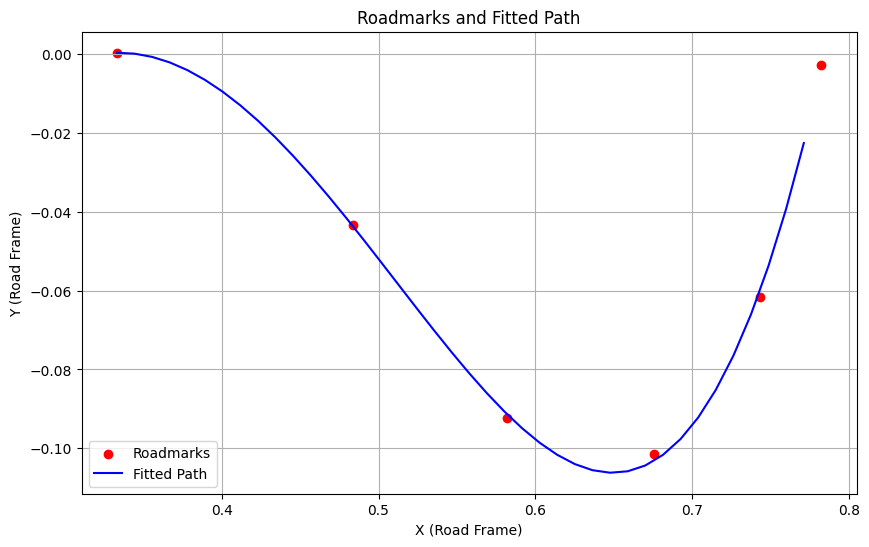

[[ 3.33046224e-01  2.98293843e-04]
 [ 3.44284469e-01  6.46355629e-05]
 [ 3.55522713e-01 -7.60252958e-04]
 [ 3.66760958e-01 -2.15848572e-03]
 [ 3.77999202e-01 -4.10900532e-03]
 [ 3.89237447e-01 -6.58758294e-03]
 [ 4.00475691e-01 -9.56681839e-03]
 [ 4.11713936e-01 -1.30161400e-02]
 [ 4.22952180e-01 -1.69018049e-02]
 [ 4.34190425e-01 -2.11868985e-02]
 [ 4.45428669e-01 -2.58313350e-02]
 [ 4.56666914e-01 -3.07918573e-02]
 [ 4.67905158e-01 -3.60220367e-02]
 [ 4.79143403e-01 -4.14722731e-02]
 [ 4.90381647e-01 -4.70897951e-02]
 [ 5.01619892e-01 -5.28186598e-02]
 [ 5.12858136e-01 -5.85997531e-02]
 [ 5.24096381e-01 -6.43707893e-02]
 [ 5.35334625e-01 -7.00663113e-02]
 [ 5.46572870e-01 -7.56176907e-02]
 [ 5.57811115e-01 -8.09531275e-02]
 [ 5.69049359e-01 -8.59976506e-02]
 [ 5.80287604e-01 -9.06731173e-02]
 [ 5.91525848e-01 -9.48982135e-02]
 [ 6.02764093e-01 -9.85884537e-02]
 [ 6.14002337e-01 -1.01656181e-01]
 [ 6.25240582e-01 -1.04010567e-01]
 [ 6.36478826e-01 -1.05557613e-01]
 [ 6.47717071e-01 -1

(-0.5, 819.5, 615.5, -0.5)

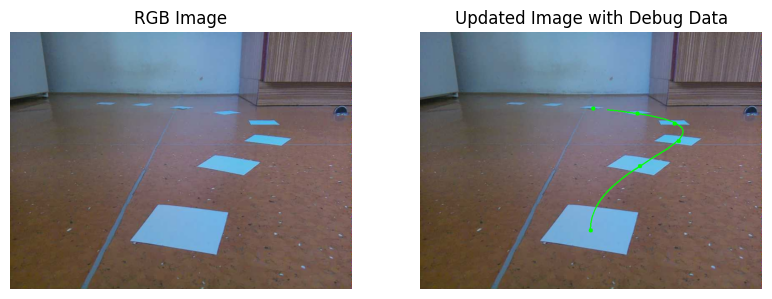

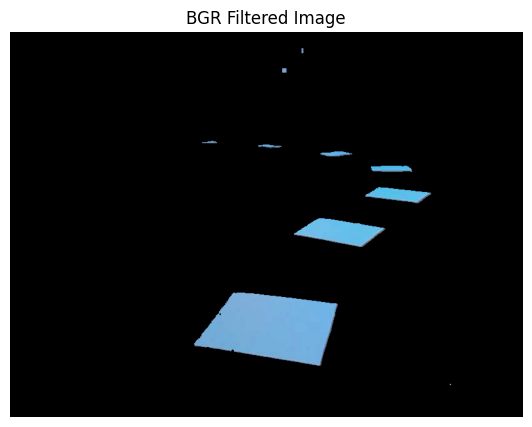

In [ ]:
# TODO: remove None checks - should be empty arrays for more clarity
def draw_debug_data(image, planner: RoadmarksPlanner) -> np.ndarray:
    image_copy = image.copy()
    roadmarks = planner.roadmarks_imgframe
    path_uv = [planner.camera.xyz_roadframe_iso88552uv(np.array([*xy, 0])) for xy in planner.path_roadframe]

    # Roadmark dots
    for u, v in roadmarks:
        cv2.circle(image_copy, (u, v), 5, (0, 255, 0), -1)

    # Planned path
    for i in range(len(path_uv) - 1):
        cv2.line(image_copy, path_uv[i], path_uv[i + 1], (0, 255, 0), 2)

    return image_copy

def plot_roadmarks(roadmarks: np.ndarray, path: np.ndarray):
    plt.figure(figsize=(10, 6))
    plt.scatter(roadmarks[:, 0], roadmarks[:, 1], color='red', label='Roadmarks')
    plt.plot(path[:, 0], path[:, 1], color='blue', label='Fitted Path')
    plt.xlabel('X (Road Frame)')
    plt.ylabel('Y (Road Frame)')
    plt.title('Roadmarks and Fitted Path')
    plt.legend()
    plt.grid()
    plt.show()


img = cv2.imdecode(np.frombuffer(jpg, np.uint8), cv2.IMREAD_COLOR)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
planner.update(img)

updated_image = draw_debug_data(rgb, planner=planner)
plot_roadmarks(planner.roadmarks_roadframe, planner.path_roadframe)
print(planner.path_roadframe)

# Plot original image
plt.figure(figsize=(15, 5))

# Plot RGB image
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.title("RGB Image")
plt.axis("off")

# Plot updated image with debug data
plt.subplot(1, 3, 2)
plt.imshow(updated_image)
plt.title("Updated Image with Debug Data")
plt.axis("off")

# Plot BGR filtered image
plt.figure(figsize=(15, 5))
plt.imshow(cv2.cvtColor(planner.img_filtered, cv2.COLOR_BGR2RGB))
plt.title("BGR Filtered Image")
plt.axis("off")
